# Exercise 7.1

Implement a **DenseNet** for image classification using the CIFAR-10 dataset. Compare the results with a **CNN**.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers


In [ ]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green, blue).

In [ ]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])


def normalize(images):
    mean = np.mean(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    sigma = np.std(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    images_normalized = (images - mean) / sigma
    return images_normalized



# normalize each pixel and color-channel separately across all images
# take 2000 images for validation from test data
x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)[:8000]
x_valid_norm = normalize(x_test)[8000:]

# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

170498071/170498071 [==============================] - 4s 0us/step
images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


**DenseNet**

We start by creating a function for the dense blocks

In [ ]:
# Creating a dense block function

def dense_block(x, n=8):
  """ Create a block of n densely connected pairs of convolutions """
  xlist = [x]
  for i in range(n):
    x = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(x)
    xlist.append(x)
    x = layers.concatenate(xlist[:], axis=-1)
  return x


Then we define the DenseNet model

I used 3 *Dense Blocks*, and 8 densely connected convolutional layers in each *Dense Block* (defined as standard in the dense_block function n=8).



In [ ]:
# Define the DenseNet model
def build_densenet():
    input_layer = layers.Input(shape=(32, 32, 3))


    # Dense blocks
    # 1st
    x = dense_block(input_layer)
    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    # 2nd
    x = dense_block(x)
    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    # 3rd
    x = dense_block(x)
    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)

    """
    for _ in range(8):  # You can adjust the number of dense blocks as needed
        x = dense_block(x)
        x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
        x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    """

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    output_layer = layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='densenet')
    return model

# Instantiate and compile the DenseNet model
model_densenet = build_densenet()

# Print the summary of the model
print(model_densenet.summary())

Model: "densenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 32, 32, 8)            224       ['input_2[0][0]']             
                                                                                                  
 concatenate_24 (Concatenat  (None, 32, 32, 11)           0         ['input_2[0][0]',             
 e)                                                                  'conv2d_28[0][0]']           
                                                                                                  
 conv2d_29 (Conv2D)          (None, 32, 32, 8)            800       ['concatenate_24[0][0]'

In [ ]:
# Compile the model
model_densenet.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

In [ ]:
# ----------------------------------------------------------
# Training the DenseNet model
# ----------------------------------------------------------

model_densenet.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=20,
    verbose=2,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_densenet.csv")],
)


Epoch 1/20
1563/1563 - 39s - loss: 1.5366 - accuracy: 0.4298 - val_loss: 1.2260 - val_accuracy: 0.5675 - 39s/epoch - 25ms/step
Epoch 2/20
1563/1563 - 27s - loss: 1.0882 - accuracy: 0.6085 - val_loss: 0.9955 - val_accuracy: 0.6480 - 27s/epoch - 17ms/step
Epoch 3/20
1563/1563 - 28s - loss: 0.9086 - accuracy: 0.6791 - val_loss: 0.9875 - val_accuracy: 0.6475 - 28s/epoch - 18ms/step
Epoch 4/20
1563/1563 - 27s - loss: 0.7904 - accuracy: 0.7208 - val_loss: 0.8022 - val_accuracy: 0.7185 - 27s/epoch - 17ms/step
Epoch 5/20
1563/1563 - 27s - loss: 0.7057 - accuracy: 0.7517 - val_loss: 0.7462 - val_accuracy: 0.7365 - 27s/epoch - 17ms/step
Epoch 6/20
1563/1563 - 28s - loss: 0.6364 - accuracy: 0.7751 - val_loss: 0.6830 - val_accuracy: 0.7540 - 28s/epoch - 18ms/step
Epoch 7/20
1563/1563 - 27s - loss: 0.5849 - accuracy: 0.7958 - val_loss: 0.6439 - val_accuracy: 0.7675 - 27s/epoch - 17ms/step
Epoch 8/20
1563/1563 - 26s - loss: 0.5443 - accuracy: 0.8088 - val_loss: 0.6539 - val_accuracy: 0.7755 - 26s/ep

In [ ]:
# Evaluate the DenseNet model
print("DenseNet Model Performance:")
headers = ["", "Loss", "Accuracy"]
table = [
    ["Train", *model_densenet.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=128)],
    ["Validation", *model_densenet.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=128)],
    ["Test", *model_densenet.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=128)],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

DenseNet Model Performance:
|            |     Loss |   Accuracy |
|------------+----------+------------|
| Train      | 0.192375 |    0.934   |
| Validation | 0.660943 |    0.8095  |
| Test       | 0.676722 |    0.80175 |


63/63 [==============================] - 1s 14ms/step


<ipython-input-2-3fb1ec9f2c41>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))


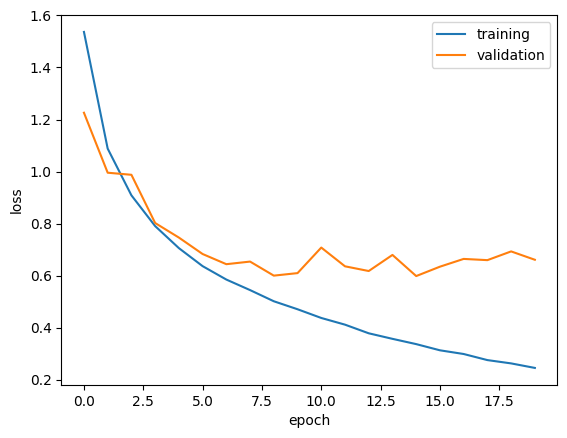

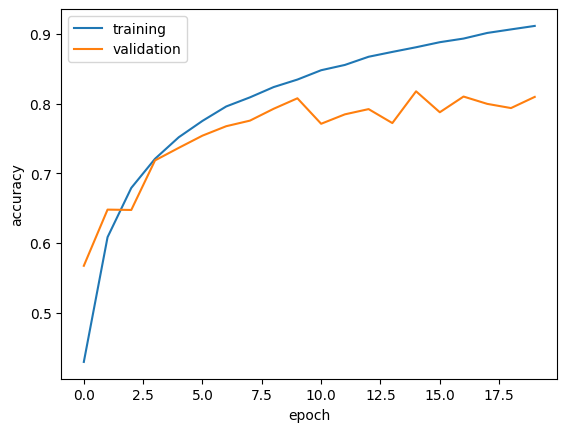

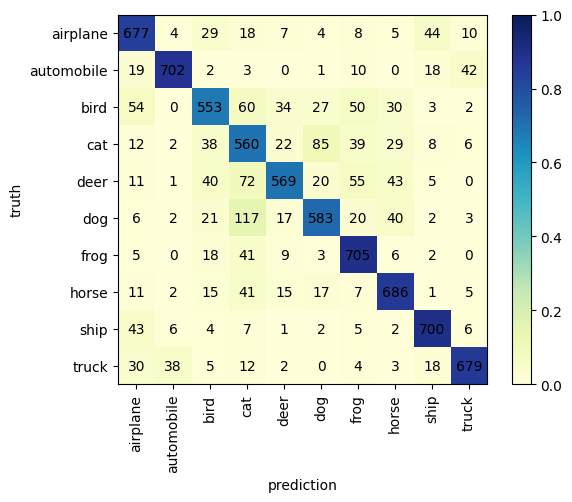

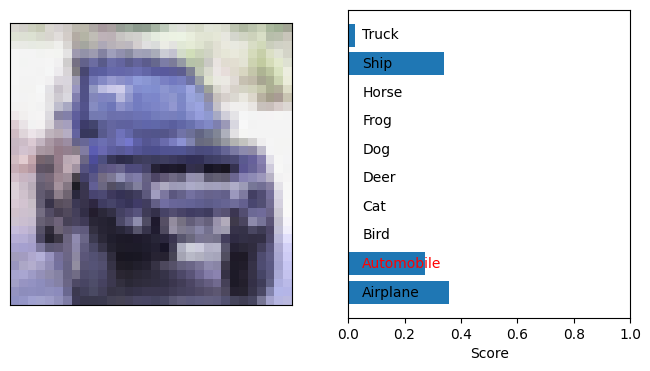

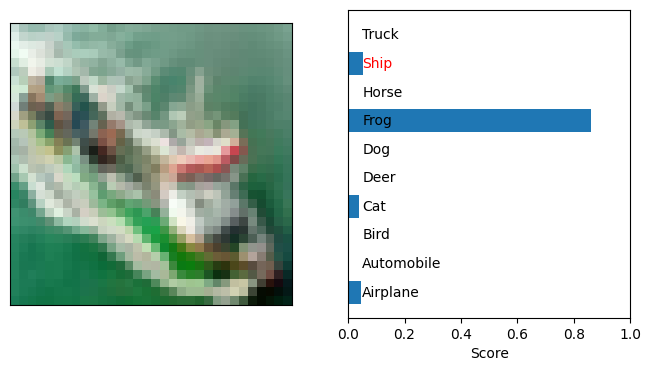

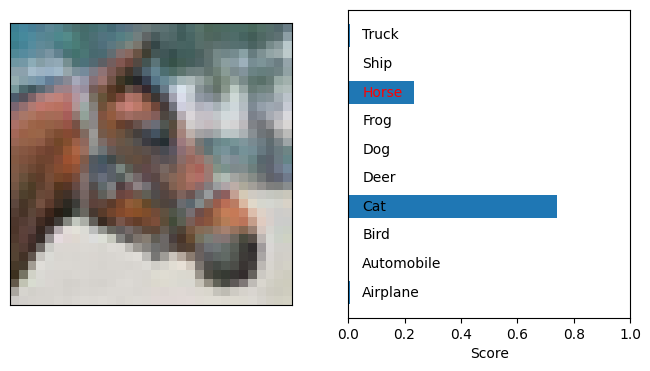

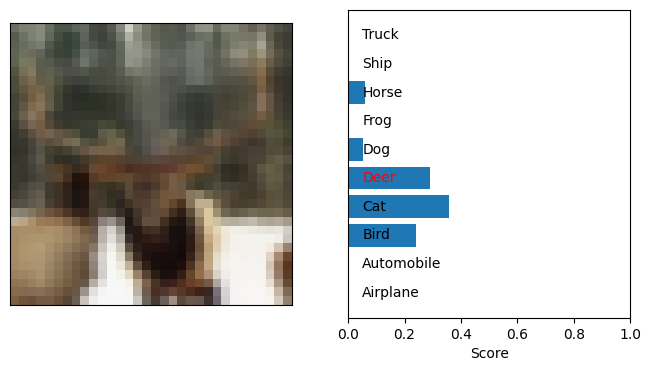

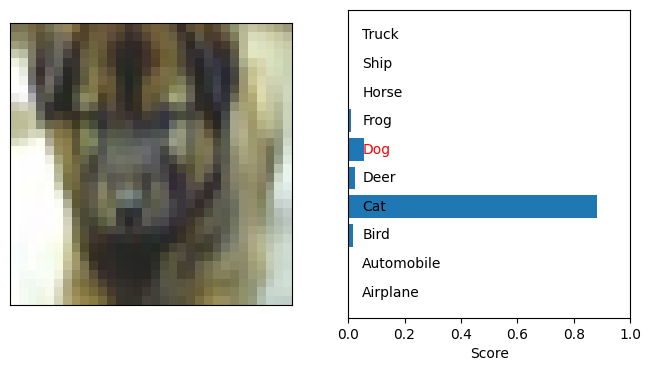

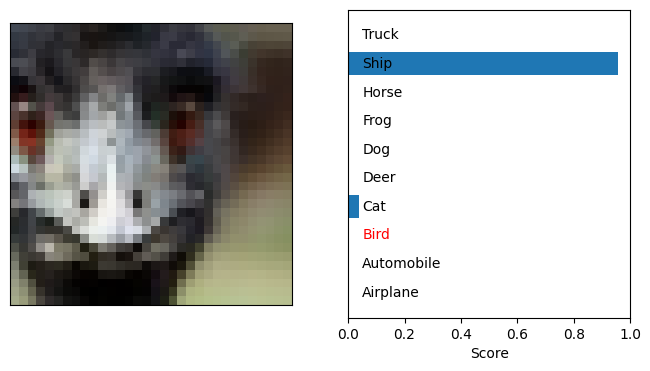

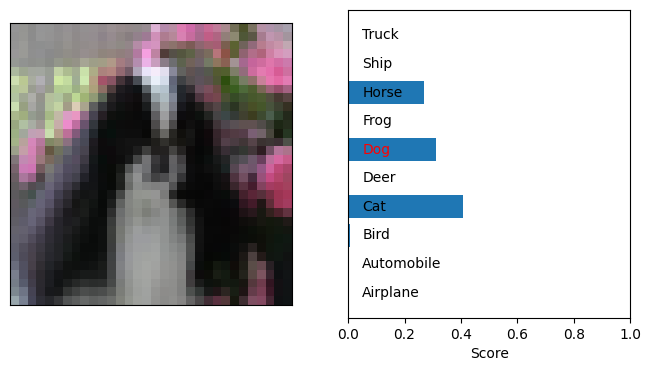

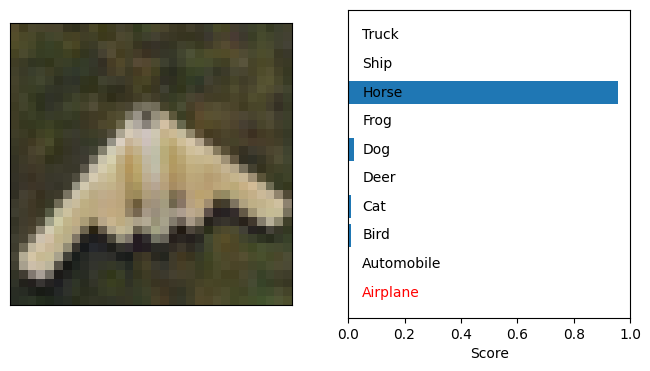

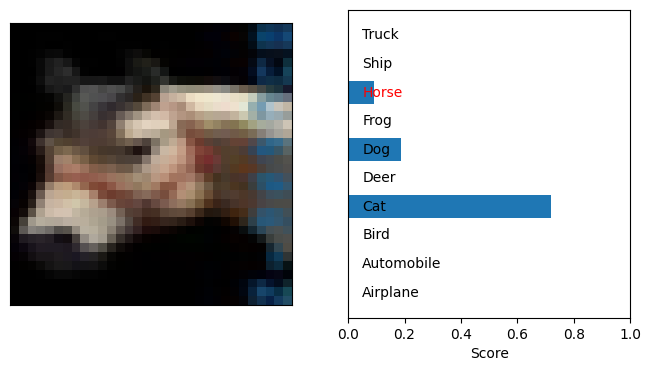

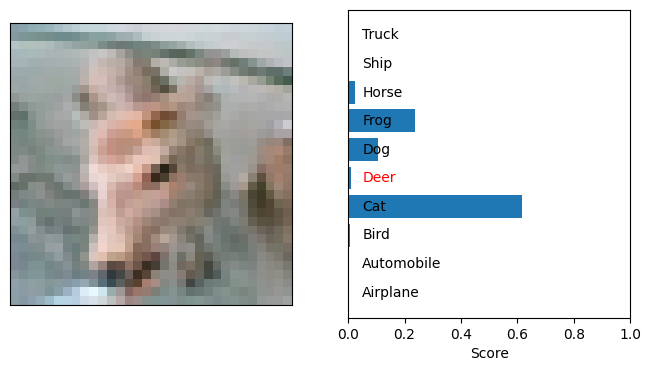

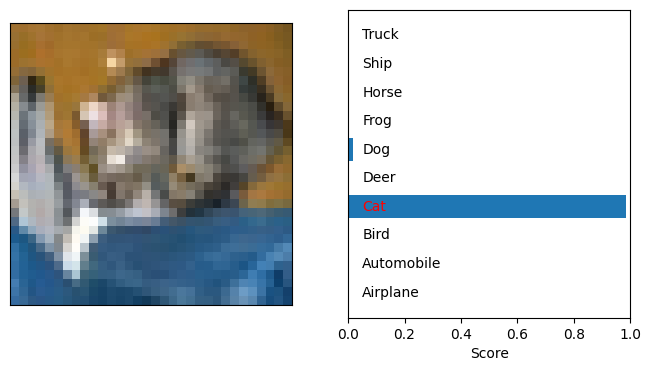

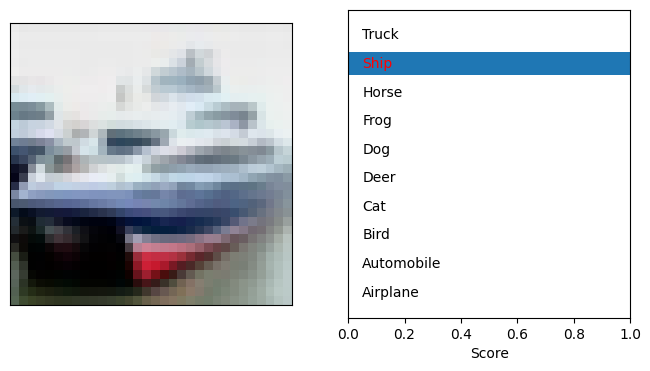

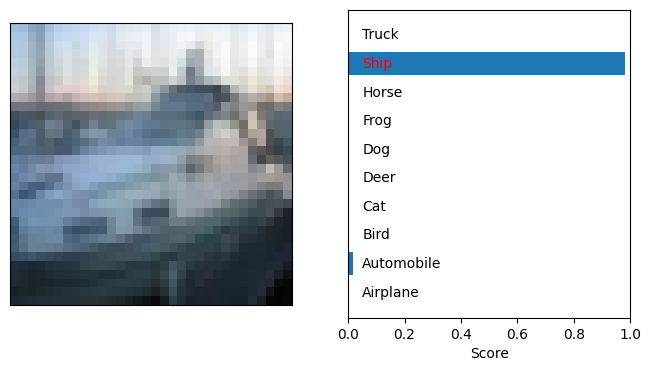

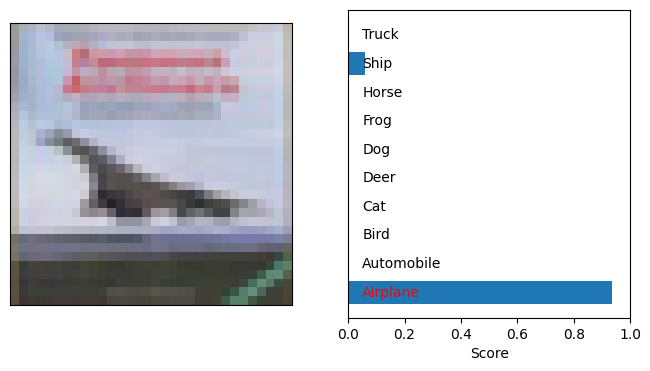

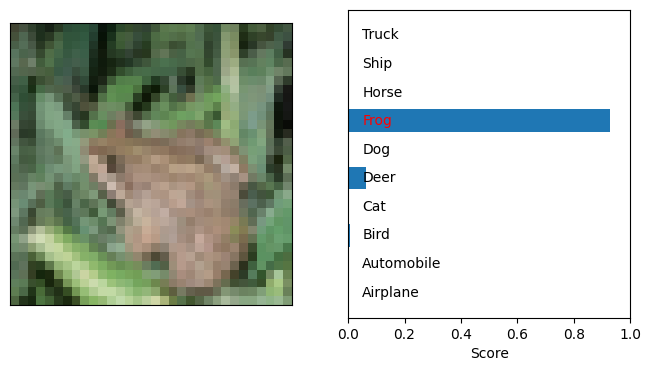

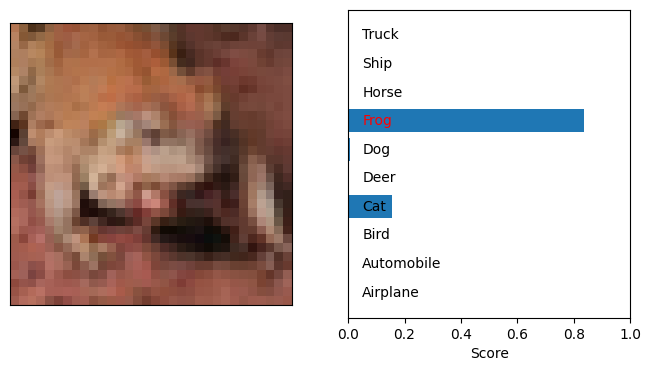

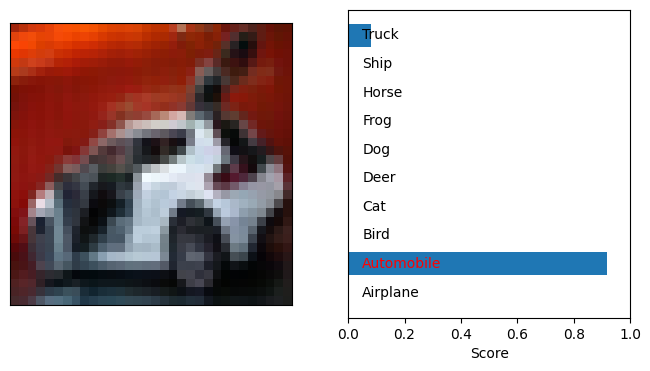

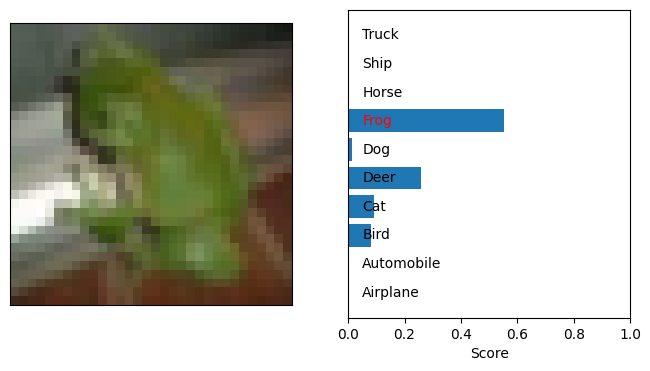

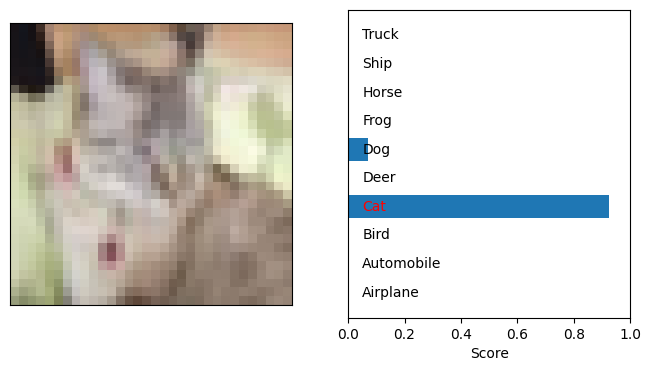

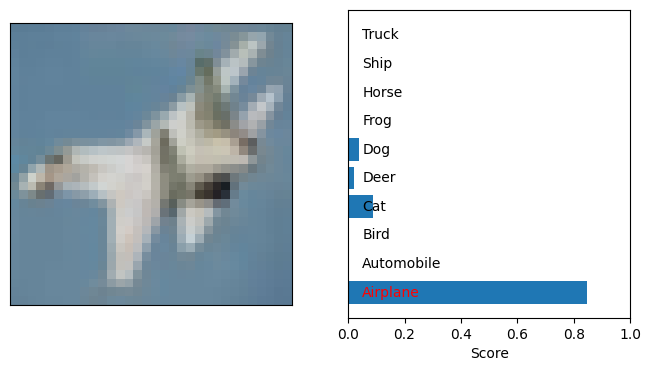

In [ ]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# Training curves
history = np.genfromtxt("history_densenet.csv", delimiter=",", names=True)

# Loss plot
fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["loss"], label="training")
ax.plot(history["epoch"], history["val_loss"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="loss")

# Accuracy plot
fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["accuracy"], label="training")
ax.plot(history["epoch"], history["val_accuracy"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="accuracy")

# Calculate predictions for the test set
y_predict_densenet = model_densenet.predict(x_test_norm, batch_size=128)

# Convert back to class labels (0-9)
y_predict_cl_densenet = np.argmax(y_predict_densenet, axis=1)
y_test_cl_densenet = np.argmax(y_test_onehot, axis=1)

# Plot confusion matrix
plot_confusion(y_test_cl_densenet, y_predict_cl_densenet)

# Compare prediction and truth
m_densenet = y_predict_cl_densenet == y_test_cl_densenet
i0_densenet = np.arange(8000)[~m_densenet]  # Misclassified images
i1_densenet = np.arange(8000)[m_densenet]   # Correctly classified images

# Original (unnormalized) test images
x_test = x_test[:8000]

# Plot first 10 false classifications
for i in i0_densenet[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict_densenet[i])

# Plot first 10 correct classifications
for i in i1_densenet[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict_densenet[i])

**Result**

From the *training accuracy vs. epochs* plot we can see that the network is not improving after about 10 epochs. It is instead starting to oscillate and become unsteady. Here Early stopping could utilize to prevent the network from overfitting and thus maybe even get a better accuracy.

**DenseNet vs CNN**

The test accuracy of CNN was ≈ 0.72, whereas DenseNet has an accuracy of ≈ 0.80. However, a deep CNN can achive better accuracy such as the one provided in the solution to 7.2 with an accurracy of ≈ 0.84.

It's worth noting the number of parameters and computation times of the different networks:

**DenseNet:**
*Total params:* 145,546;
*Time:* 9 min

**CNN:**
*Total params:* 25,578,
*Time:* 3,2 min

**DCNN:**
*Total params:* 2,181,290,
*Time:* 15,7 min

We can see that DenseNet demonstrates comparable accuracy to a deep CNN while utilizing a fraction of the parameters and just over half of the computation time.

From the confusion matrix we can also see the improvment when using DenseNet compared to CNN. However, same thing here, a deep CNN is still better at categorising the different images:

**DenseNet**

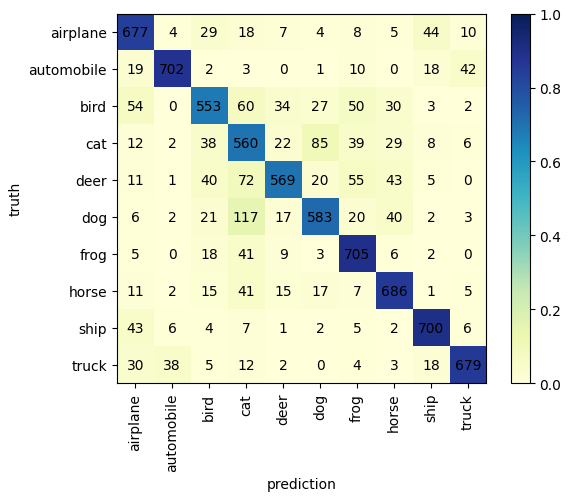

**CNN**

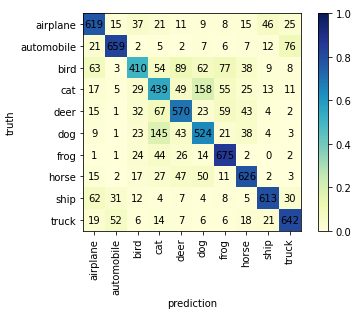

**DCNN**

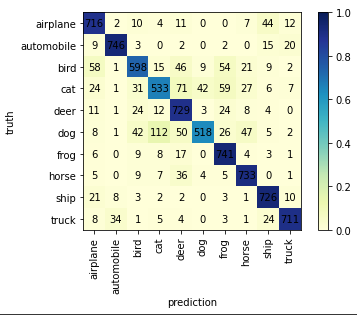
